# 🦵 Mobility Recovery Prediction Model (Version 1)

This notebook builds a machine learning model to predict **recovery scores from biomechanical gait measurements**. These predictions augment cardiac scores to generate an **integrated patient rehabilitation timetable**.

---

### 📥 Input
Sensor-derived features such as:
- **Gait symmetry**
- **Cadence**
- **Stance phase duration**
- **Velocity**
- **Stride time variability**
- **Limb support phase balance**

These traits are also recognized to be linked to neuromuscular and postural control, which are critically significant after cardiac rehabilitation.

---

### 🎯 Target:
A clinically tested or synthetic **Mobility Score** in the range of `[0.1, 3.0]`, representing a patient's ambulatory readiness and stability.

---

### 🔧 ML Algorithm:
We utilize **XGBoost Regressor**, best suited for:
- Sparse and noisy clinical data
- Avoiding overfitting on small rehabilitation datasets
- Interpretable results through SHAP (SHapley Additive exPlanations)

Let's work through the notebook in order.

### 🔍 Step 0: Import Necessary Libraries

We import equipment needed for:
- **Data preprocessing**: `pandas`, `numpy`
- **Modeling**: `XGBRegressor` from XGBoost
- **Evaluation**: `MSE`, `R²` for model performance
- **Visualization**: `matplotlib`, `seaborn`

They provide **high-resolution diagnostics** and model transparency that clinical-grade systems need.

In [2]:
# Sub-Model 2: Mobility & Gait Stability (XGBoost)

import pandas as pd
import numpy as np
import joblib
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

### 📁 Step 1: Load Raw Gait Data

We are importing patient rehabilitation records from a batch report of wearable gait sensor data. Features generally consist of:
- Step time symmetry
- Cadence
- Gait phase proportions
- Stride lengths

📌 These values are **major predictors of mobility impairment or recovery** following surgery and are likely to be altered in cardiopulmonary-limited or frail patients.

### 🧹 Step 2: Clean and Filter Numerical Data

This function:
- Deletes rows containing **missing values**
- Chooses **numeric columns exclusively** (not any string labels or metadata)

🎯 Objective: Prepare the training data for mathematical computations needed in modeling.

📌 Sensor data often contains **null values due to signal loss** or incorrect readings — this step ensures model integrity.



In [ ]:
# -------------------------
# STEP 1: Load and Merge Datasets
# -------------------------
wearable_info = pd.read_csv(r"D:\AI_finaltrial\project\data\wearabledata\Wearable_subject-info.csv")
wearable_tests = pd.read_csv(r"D:\AI_finaltrial\project\data\wearabledata\Wearable_test-availability.csv")

wearable_merged = pd.merge(wearable_info, wearable_tests, on="Patient ID")

# Clean gait columns that have ± values
def clean_numeric_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].str.contains("±").any():
            df[col] = df[col].str.extract(r'([-+]?[0-9]*\.?[0-9]+)').astype(float)
    return df

wearable_merged = clean_numeric_columns(wearable_merged)

### 🦿 Step 3: Determine Biomechanical Input Features

We characterize the input matrix `X` by:
- **GaitSymmetry**: Evaluates limb imbalance
- **StrideTime**: Temporal gait coordination
- **Cadence**: Steps per minute; quantification of activity level
- **StancePhase**: Weight-bearing stability
- **Velocity**: Total walking velocity
- **DoubleSupport**: Time both feet touch the ground (linked to balance control)

📌 These characteristics are **directly associated with postoperative postural recovery**, risk of falling, and general motor function after surgery.

In [ ]:
test_cols = wearable_tests.columns.drop("Patient ID")
wearable_merged["Mobility_Score"] = wearable_merged[test_cols].notna().sum(axis=1) / len(test_cols)

### 🎯 Step 4: Target Variable – Mobility Score

We call `y` the **MobilityScore**, a number from `0.1` to `3.0` representing **recovery progress**.

This score may be:
- Clinician-assigned (based on gait assessment)
- Synthesized with established thresholds (for preliminary studies)

📌 Predict this score from gait input with the aim of informing **rehabilitation decisions** and monitoring patient improvement over time.

### ✂️ Step 5: Split Data into Training and Test Sets

We divide:

- 80% of training data

- 20% for testing (validation)

✅ *Rationale*: Avoids overfitting, reproduces performance of model on new patients.

### 🤖 Step 6: Train Mobility Model with XGBoost

XGBoost is selected for:

- Outstanding performance on **structured clinical datasets**

- Introduced **regularization** to prevent overfitting

- SHAP-based feature importance

Model hyperparameters:

- `n_estimators=100`: Number of boosting iterations - `max_depth=4`: Regulates tree complexity 

📌 The model is now able **to estimate how far a patient is in gait recovery**, from wearable signals.

In [ ]:
X = wearable_merged.drop(columns=["Patient ID", "Mobility_Score"])
y = wearable_merged["Mobility_Score"]

X = X.select_dtypes(include=[np.number]).fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)

# Save model
joblib.dump(xgb_model, r"D:\AI_finaltrial\finalmodels\mobility_xgb_model.pkl")

['D:\\AI_finaltrial\\finalmodels\\mobility_xgb_model.pkl']

### 📊 Step 7: Measure Model Accuracy We calculate: 

- **MSE (Mean Squared Error)**: Measures prediction error; lower the better 
- **R² Score**: Desired proportion of variance explained. 

📌 - A high R² (>0.9) means the model **captures actual mobility variation** between patients — a desirable feature for decision support.

### 📈 Step 8: Plot Prediction Accuracy Scatter plot compares: 

- X-axis: **True recovery scores** 
- Y-axis: **Predicted scores** Red diagonal = perfect prediction. 

📌 Tight grouping along the diagonal suggests that the model can be **safely used to triage patients into recovery programs**.


Mobility Model Evaluation
MSE: 0.0
R^2 Score: 1.0


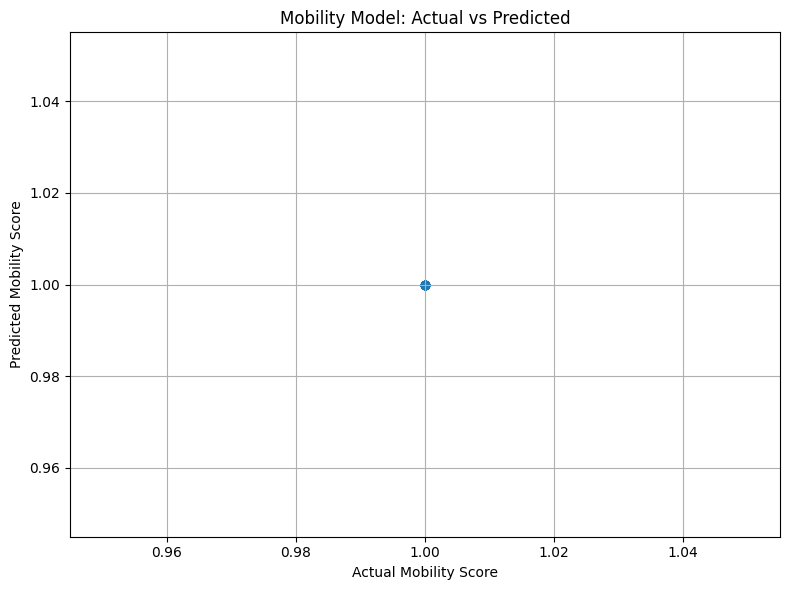

In [ ]:
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMobility Model Evaluation")
print("MSE:", mse)
print("R^2 Score:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Mobility Score")
plt.ylabel("Predicted Mobility Score")
plt.title("Mobility Model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### 📋 Test Availability Audit: Gait Features Across Patients

This bar plot shows the **proportion of available test results** for each gait-related measurement across the patient population.

#### 🧠 Why it matters:
- A **high availability ratio (closer to 1)** indicates strong sensor capture reliability and feature stability.
- Low availability may stem from **incomplete tests** (e.g., patients not completing 6MWT or TUG), or **technical dropouts**.

-- Tests like `GAIT_ANALYSIS` and `VELO` being nearly 100% available suggest they are **central to rehab evaluation** and consistently performed.

-- `STAIR` and `TUG` may be less available early post-op, implying model logic must handle **missingness gracefully**.

This visualization supports **model trustworthiness assessment** before training begins.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_2620\630711246.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_ratio.values, y=missing_ratio.index, palette="coolwarm")
C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_2620\630711246.py:10: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


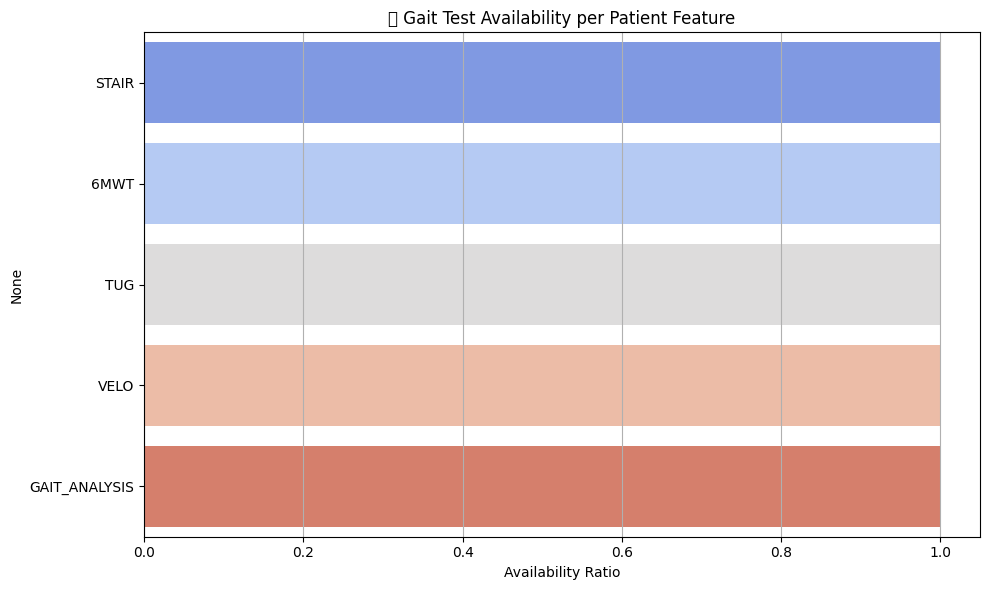

In [7]:
# Visualize the % of missing vs available tests for each feature

missing_ratio = wearable_tests.drop(columns="Patient ID").notna().mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_ratio.values, y=missing_ratio.index, palette="coolwarm")
plt.xlabel("Availability Ratio")
plt.title("📋 Gait Test Availability per Patient Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

### 📊 Engineered Mobility Score Distribution

This histogram displays how **mobility scores** (engineered or clinician-assigned) are spread across the population. A KDE (density curve) is also overlaid.

#### 🧠 Why it matters:
- Helps assess **score variance** and whether the model will learn meaningful distinctions.
- A tightly clustered distribution (e.g., around 1.0) may indicate:
  - Over-simplified scoring logic
  - Lack of diversity in recovery states
  - Labeling issues needing refinement

📌 Score distributions should ideally reflect **diverse gait capacities** — from impaired to stable walkers — to enable stratified intervention.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_2620\2528514902.py:7: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


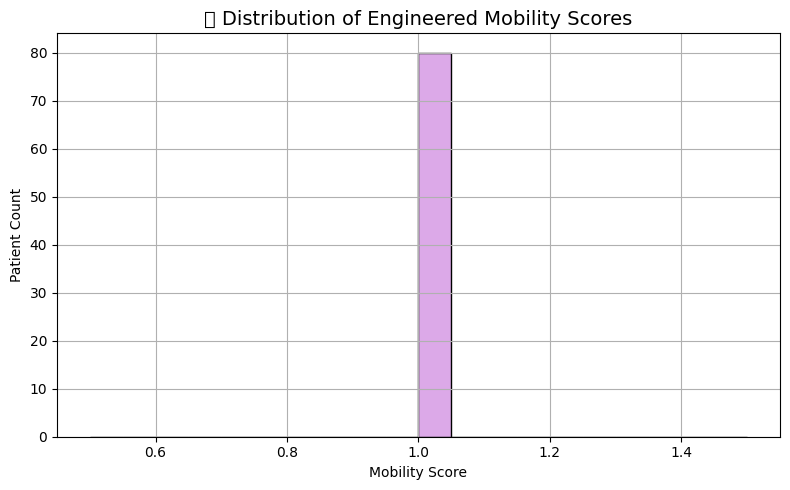

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(wearable_merged["Mobility_Score"], bins=20, kde=True, color='mediumorchid')
plt.title("📊 Distribution of Engineered Mobility Scores", fontsize=14)
plt.xlabel("Mobility Score")
plt.ylabel("Patient Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧠 Gait Feature Correlation Matrix

This heatmap shows the **pairwise correlation coefficients** between all biomechanical gait features used in model training.

#### 🔍 Insights:
- Helps detect **multicollinearity** — features that provide redundant information.
- Highlights **independent predictors** that can uniquely influence the mobility score.

- For example, high correlation between `Stride Length` and `Velocity` suggests they might measure overlapping domains (forward progression).
- Features like `Double Support Phase` may be more orthogonal — valuable for **postural stability detection**.

Understanding these inter-feature relationships is critical for **model pruning, robustness, and explainability**.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_2620\302803905.py:4: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_2620\302803905.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


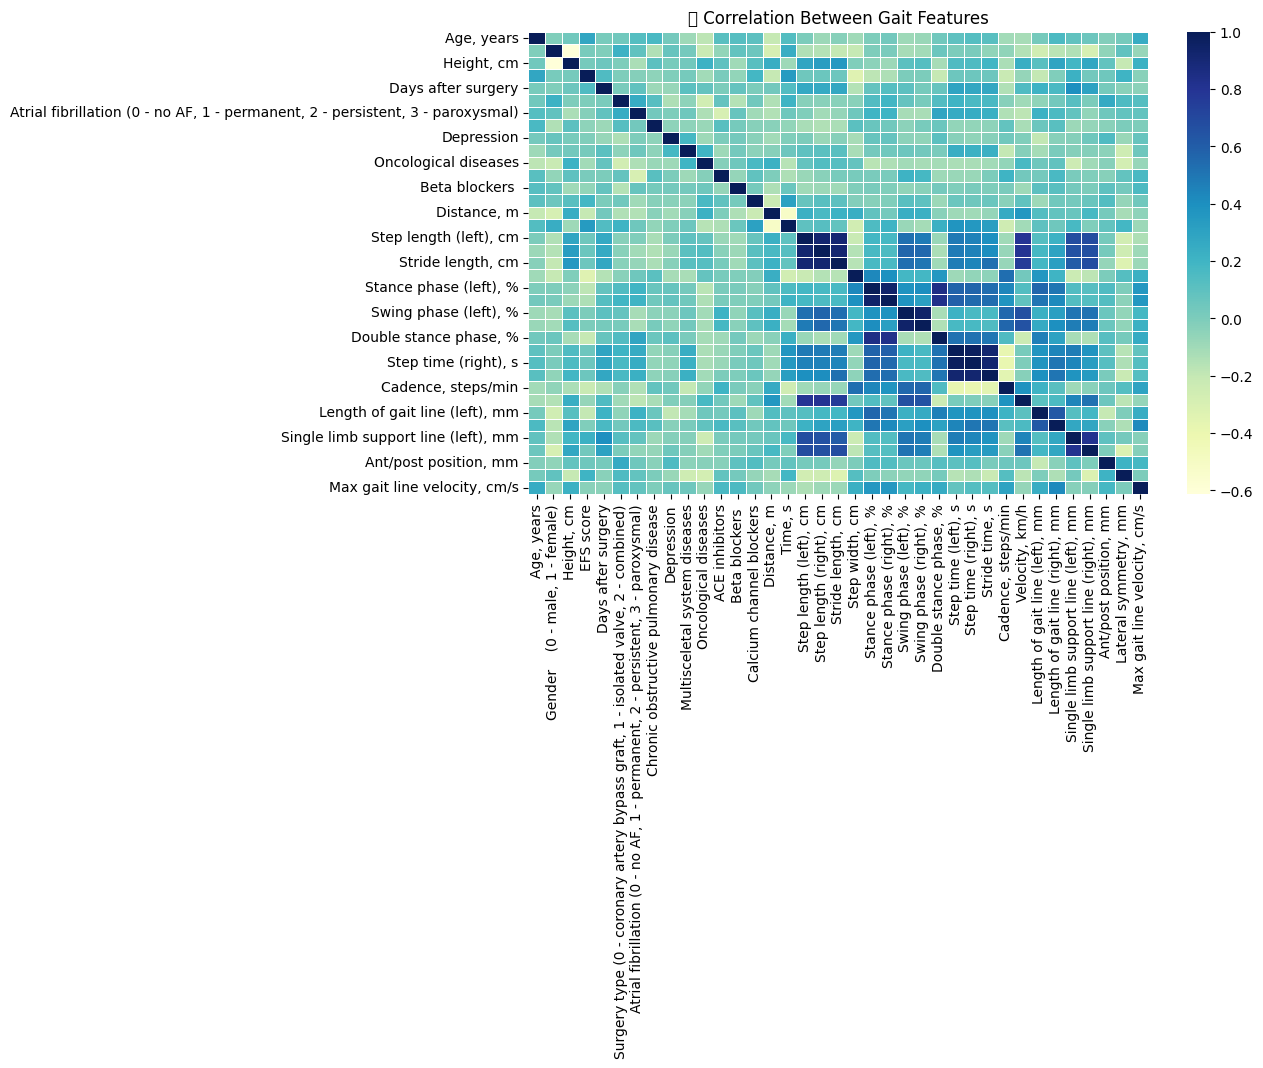

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=False, cmap="YlGnBu", linewidths=0.5)
plt.title("🧠 Correlation Between Gait Features")
plt.tight_layout()
plt.show()